# Vanilla GAN with Tensorflow

***Goal***: Use vanilla GAN to generate samples from N(0,1) using input data from uniform[0,1]

---

In [30]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
#from tensorflow.keras.utils.vis_utils import plot_model
import time

## 1. Prepare the data set

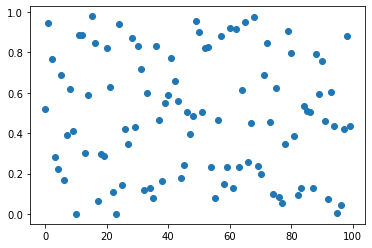

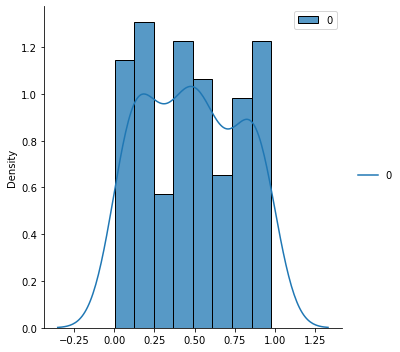

In [31]:
N = 100 # size of the data set
np.random.seed(23)

# generate n real samples with class labels
def generate_real_samples(n):
    # generate inputs in [-0.5, 0.5]
    X = np.random.uniform(size=(n,1))
    # generate class labels
    y = np.ones((n, 1))
    return X, y
 
# generate samples
data,_ = generate_real_samples(N)
# plot samples
plt.scatter(range(N), data)
sns.displot(data,kind='kde')
sns.histplot(data,stat = 'density')
plt.show()

## 2. Define the model

### 2.1 Discriminator model

In [32]:
# define the standalone discriminator model
def define_discriminator(n_inputs=1):
    model = Sequential()
    model.add(Dense(5, activation='relu', input_dim=n_inputs))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
 
# define the discriminator model
model = define_discriminator()
# summarize the model
model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_46 (Dense)             (None, 5)                 10        
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 6         
Total params: 16
Trainable params: 16
Non-trainable params: 0
_________________________________________________________________


In [33]:
# generate n fake samples with class labels
def generate_fake_samples(n):
    # generate normal inputs with mu = 0, sigma = 2
    X = np.random.normal(0,2,size=(n,1))
    # generate class labels
    y = np.zeros((n, 1))
    return X, y
# test
generate_fake_samples(3)

(array([[ 1.84199167],
        [ 3.86617967],
        [-1.59072644]]),
 array([[0.],
        [0.],
        [0.]]))

In [34]:
# train the discriminator model
def train_discriminator(model, n_epochs=1000, n_batch=128):
    half_batch = int(n_batch / 2)
    # run epochs manually
    for i in range(n_epochs):
        # generate real examples
        X_real, y_real = generate_real_samples(half_batch)
        # update model
        model.train_on_batch(X_real, y_real)
        # generate fake examples
        X_fake, y_fake = generate_fake_samples(half_batch)
        # update model
        model.train_on_batch(X_fake, y_fake)
        # evaluate the model
        if i % 100 == 0:
            _, acc_real = model.evaluate(X_real, y_real, verbose=0)
            _, acc_fake = model.evaluate(X_fake, y_fake, verbose=0)
            print('Epoch {0}: Accuracy of real data = {1}, fake data = {2}'.format(i, acc_real, acc_fake))
# define the discriminator model
model = define_discriminator()
# fit the model
train_discriminator(model)

Epoch 0: Accuracy of real data = 0.015625, fake data = 0.5
Epoch 100: Accuracy of real data = 0.46875, fake data = 0.453125
Epoch 200: Accuracy of real data = 0.78125, fake data = 0.515625
Epoch 300: Accuracy of real data = 0.875, fake data = 0.765625
Epoch 400: Accuracy of real data = 1.0, fake data = 0.8125
Epoch 500: Accuracy of real data = 1.0, fake data = 0.703125
Epoch 600: Accuracy of real data = 1.0, fake data = 0.84375
Epoch 700: Accuracy of real data = 1.0, fake data = 0.78125
Epoch 800: Accuracy of real data = 1.0, fake data = 0.84375
Epoch 900: Accuracy of real data = 1.0, fake data = 0.65625


## 2.2 Generator Model

In [35]:
# define the standalone generator model
def define_generator(latent_dim, n_outputs=1):
	model = Sequential()
	model.add(Dense(5, activation='relu', input_dim=latent_dim))
	model.add(Dense(n_outputs, activation='linear'))
	return model

# define the discriminator model
model = define_generator(5)
# summarize the model
model.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_50 (Dense)             (None, 5)                 30        
_________________________________________________________________
dense_51 (Dense)             (None, 1)                 6         
Total params: 36
Trainable params: 36
Non-trainable params: 0
_________________________________________________________________


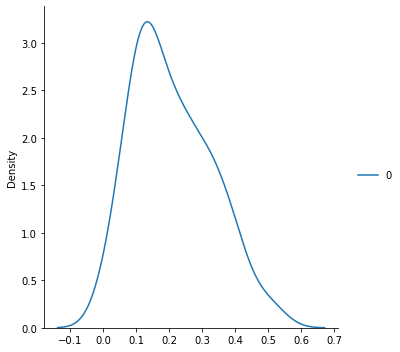

In [36]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
    # generate points in the latent space
    # reshape into a batch of inputs for the network
    x_input = np.random.normal(5,3,size = (n,latent_dim))
    #sns.displot(x_input,kind='kde')
    return x_input

# use the generator to generate n fake examples and plot the results
def generate_fake_samples(generator, latent_dim, n):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels
	y = np.zeros((n, 1))
	return X, y

# size of the latent space
latent_dim = 1
# define the discriminator model
model = define_generator(latent_dim)
# generate and plot generated samples
fake_data, _ = generate_fake_samples(model, latent_dim, 100)
# plot the results
sns.displot(fake_data,kind='kde')
plt.show()

## 2.3. Assemble model

In [37]:
def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam')
	return model

# Check
# size of the latent space
latent_dim = 5
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# summarize gan model
gan_model.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_30 (Sequential)   (None, 1)                 36        
_________________________________________________________________
sequential_29 (Sequential)   (None, 1)                 16        
Total params: 52
Trainable params: 36
Non-trainable params: 16
_________________________________________________________________


In [38]:
# evaluate the discriminator and plot real and fake points
def summarize_performance(epoch, generator, discriminator, latent_dim, n=100):
    # prepare real samples
    x_real, y_real = generate_real_samples(n)
    # evaluate discriminator on real examples
    _, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
    # evaluate discriminator on fake examples
    _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print(epoch, acc_real, acc_fake)
    # scatter plot real and fake data points
    plt.figure(figsize=(6, 6))
    plt.scatter(range(len(x_real)),x_real, color = 'red', label = 'Real')
    plt.scatter(range(len(x_fake)),x_fake, color = 'blue', label = 'Fake')
    plt.legend()
    plt.show()

# 3. Train the generator and discriminator

1999 1.0 0.0
3999 1.0 0.0
5999 1.0 0.0


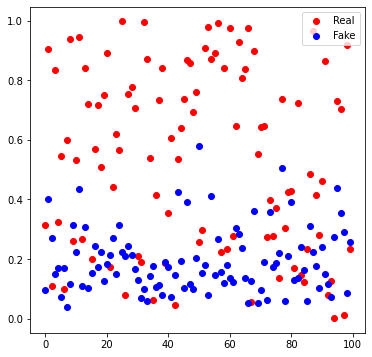

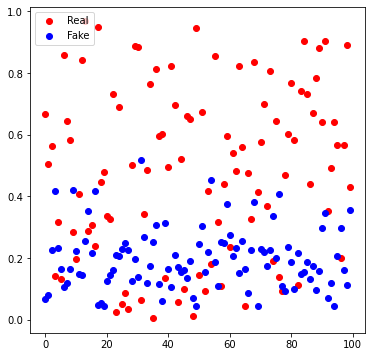

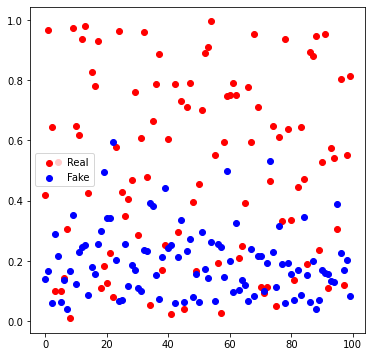

In [ ]:
%%time
# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=256, n_eval=2000):
	# determine half the size of one batch, for updating the discriminator
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# prepare real samples
		x_real, y_real = generate_real_samples(half_batch)
		# prepare fake examples
		x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
		# update discriminator
		d_model.train_on_batch(x_real, y_real)
		d_model.train_on_batch(x_fake, y_fake)
		# prepare points in latent space as input for the generator
		x_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = np.ones((n_batch, 1))
		# update the generator via the discriminator's error
		gan_model.train_on_batch(x_gan, y_gan)
		# evaluate the model every n_eval epochs
		if (i+1) % n_eval == 0:
			summarize_performance(i, g_model, d_model, latent_dim)

# size of the latent space
latent_dim = 1
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# train model
train(generator, discriminator, gan_model, latent_dim)